## These models predict deltaI and deltaR using training data created with the MATLAB code HexagonSpec_TrainingData_PS. Before training these models, we take out the first peak information. The sacle factor used to create the data was 0.91


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
# Creating Column Names 
peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# subset = 5 This would be used if we wanted a different number of spec points spaced differently. 
energy_names2 = energy_names[50:] # This would be used if we wanted to exclude the specs of the first peak -400 to -350 

#col_names2 = ['deltaI', 'deltaR', 'scale factor']+ peak_names + locs_names + width_names + prom_names
#col_names1 = ['deltaI', 'deltaR', 'scale factor'] + energy_names
# col_names_both = col_names2 + energy_names

col_names1 = ['deltaI', 'deltaR'] + energy_names # this would be used if we didn't want the scale factor 
col_names2 = ['deltaI', 'deltaR']+ peak_names + locs_names + width_names + prom_names # this one would be used if we didn't have the scale factor 
#col_names_both = col_names2 + energy_names
col_names_both = col_names2 + energy_names2 # this would be used if we wanted to exclude the first peak specs 


In [3]:
# Loading Training Data 
# Spec Points
data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData180806_PS_sf_0.91_specPoints.csv', header = None, names = col_names1)
# Peak Info 
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData180806_PS_sf_0.91_peakinfo.csv', header = None, names = col_names2)


In [4]:
# Manipulating Training Data 
col_names1a = ['deltaI', 'deltaR'] + energy_names2 # this would be used if we wanted to exclude the first peak 
data1 = data1[col_names1a] # this would be used if we wanted to exclude the first peak 

# Making combination data peak info + spec points  
data = data2.join(data1.drop(['deltaI', 'deltaR'], axis = 1), how = 'left')
data = data[col_names_both]

X1 = data1.drop(['deltaI', 'deltaR'], axis = 1)
Y1 = data1[['deltaI', 'deltaR']]

X2 = data2.drop(['deltaI', 'deltaR', 'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
# X2 = data2.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
Y2 = data2[['deltaI', 'deltaR']]

X = data.drop(['deltaI', 'deltaR',  'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
# X = data.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
Y = data[['deltaI', 'deltaR']]

In [5]:
# Manipulating Training Data 
#col_names1a = ['deltaI', 'deltaR', 'scale factor'] + energy_names2 # this would be used if we wanted to exclude the first peak 
#data1 = data1[col_names1a] # this would be used if we wanted to exclude the first peak 

# Making combination data peak info + spec points  
#data = data2.join(data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1), how = 'left')
#data = data[col_names_both]

#X1 = data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
#Y1 = data1[['deltaI', 'deltaR', 'scale factor']]

#X2 = data2.drop(['deltaI', 'deltaR', 'scale factor', 'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
# X2 = data2.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
#Y2 = data2[['deltaI', 'deltaR', 'scale factor']]

#X = data.drop(['deltaI', 'deltaR', 'scale factor',  'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
# X = data.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
#Y = data[['deltaI', 'deltaR', 'scale factor']]

In [6]:
# Splitting Training and Testing Data 
ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

In [7]:
# Checking Combination Data
data.head()

,deltaI,deltaR,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,5.5087,3.5974,2.7975,2.0804,-0.340,-0.208,-0.020,0.212,...,1.6031,1.5842,1.5593,1.5284,1.4934,1.45480,1.41400,1.37210,1.32930,1.28750
1,0.91338,-0.57749,6.9126,4.4603,3.4157,2.4903,-0.340,-0.208,-0.020,0.212,...,1.8295,1.7879,1.7366,1.6770,1.6128,1.54520,1.47680,1.40930,1.34340,1.28120
2,0.27850,-0.71176,12.2540,8.2202,6.2058,4.2713,-0.342,-0.212,-0.026,0.202,...,1.5216,1.3706,1.2394,1.1253,1.0287,0.94455,0.87313,0.81182,0.75896,0.71429
3,0.96489,-1.32320,8.3065,5.2290,3.9714,2.8863,-0.338,-0.204,-0.016,0.218,...,2.1412,2.1412,2.1172,2.0696,2.0030,1.92170,1.83020,1.73400,1.63560,1.53980
4,0.95717,-0.80837,7.3829,4.8566,3.6812,2.6820,-0.340,-0.206,-0.018,0.214,...,1.9731,1.9314,1.8756,1.8076,1.7323,1.65170,1.56950,1.48830,1.40890,1.33410


In [8]:
# Checking Combination Data 
X.head()

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,3.5974,2.7975,2.0804,-0.208,-0.020,0.212,0.025060,0.036220,0.044806,3.2186,...,1.6031,1.5842,1.5593,1.5284,1.4934,1.45480,1.41400,1.37210,1.32930,1.28750
1,4.4603,3.4157,2.4903,-0.208,-0.020,0.212,0.020531,0.030576,0.038398,4.1489,...,1.8295,1.7879,1.7366,1.6770,1.6128,1.54520,1.47680,1.40930,1.34340,1.28120
2,8.2202,6.2058,4.2713,-0.212,-0.026,0.202,0.011315,0.017493,0.023716,8.0477,...,1.5216,1.3706,1.2394,1.1253,1.0287,0.94455,0.87313,0.81182,0.75896,0.71429
3,5.2290,3.9714,2.8863,-0.204,-0.016,0.218,0.017831,0.026988,0.034299,4.9624,...,2.1412,2.1412,2.1172,2.0696,2.0030,1.92170,1.83020,1.73400,1.63560,1.53980
4,4.8566,3.6812,2.6820,-0.206,-0.018,0.214,0.018983,0.028720,0.036153,4.5687,...,1.9731,1.9314,1.8756,1.8076,1.7323,1.65170,1.56950,1.48830,1.40890,1.33410


In [9]:
# Checking Spec points Data 
X1.head()

,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,E_-286_mV,E_-284_mV,E_-282_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.27215,0.26020,0.25026,0.242160,0.235600,0.230460,0.226320,0.223450,0.221630,0.220760,...,1.6031,1.5842,1.5593,1.5284,1.4934,1.45480,1.41400,1.37210,1.32930,1.28750
1,0.21815,0.20850,0.20049,0.193990,0.188750,0.184680,0.181360,0.179110,0.177720,0.177080,...,1.8295,1.7879,1.7366,1.6770,1.6128,1.54520,1.47680,1.40930,1.34340,1.28120
2,0.10968,0.10543,0.10198,0.099266,0.097185,0.095687,0.094463,0.093817,0.093678,0.093946,...,1.5216,1.3706,1.2394,1.1253,1.0287,0.94455,0.87313,0.81182,0.75896,0.71429
3,0.19202,0.18267,0.17490,0.168540,0.163340,0.159250,0.155790,0.153340,0.151620,0.150540,...,2.1412,2.1412,2.1172,2.0696,2.0030,1.92170,1.83020,1.73400,1.63560,1.53980
4,0.20261,0.19338,0.18572,0.179490,0.174450,0.170520,0.167270,0.165050,0.163610,0.162870,...,1.9731,1.9314,1.8756,1.8076,1.7323,1.65170,1.56950,1.48830,1.40890,1.33410


In [10]:
# Checking Spec Points Data 
data1.head()

,deltaI,deltaR,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,E_-286_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,0.27215,0.26020,0.25026,0.242160,0.235600,0.230460,0.226320,0.223450,...,1.6031,1.5842,1.5593,1.5284,1.4934,1.45480,1.41400,1.37210,1.32930,1.28750
1,0.91338,-0.57749,0.21815,0.20850,0.20049,0.193990,0.188750,0.184680,0.181360,0.179110,...,1.8295,1.7879,1.7366,1.6770,1.6128,1.54520,1.47680,1.40930,1.34340,1.28120
2,0.27850,-0.71176,0.10968,0.10543,0.10198,0.099266,0.097185,0.095687,0.094463,0.093817,...,1.5216,1.3706,1.2394,1.1253,1.0287,0.94455,0.87313,0.81182,0.75896,0.71429
3,0.96489,-1.32320,0.19202,0.18267,0.17490,0.168540,0.163340,0.159250,0.155790,0.153340,...,2.1412,2.1412,2.1172,2.0696,2.0030,1.92170,1.83020,1.73400,1.63560,1.53980
4,0.95717,-0.80837,0.20261,0.19338,0.18572,0.179490,0.174450,0.170520,0.167270,0.165050,...,1.9731,1.9314,1.8756,1.8076,1.7323,1.65170,1.56950,1.48830,1.40890,1.33410


In [11]:
# Checking Peak Info Data 
X2.head()

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,prom3,prom4
0,3.5974,2.7975,2.0804,-0.208,-0.020,0.212,0.025060,0.036220,0.044806,3.2186,2.2583,1.3689
1,4.4603,3.4157,2.4903,-0.208,-0.020,0.212,0.020531,0.030576,0.038398,4.1489,2.9626,1.8493
2,8.2202,6.2058,4.2713,-0.212,-0.026,0.202,0.011315,0.017493,0.023716,8.0477,5.9485,3.8434
3,5.2290,3.9714,2.8863,-0.204,-0.016,0.218,0.017831,0.026988,0.034299,4.9624,3.5756,2.3111
4,4.8566,3.6812,2.6820,-0.206,-0.018,0.214,0.018983,0.028720,0.036153,4.5687,3.2588,2.0726


In [12]:
# Checking Peak Info Data 
data2.head()

,deltaI,deltaR,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,0.81472,-0.14798,5.5087,3.5974,2.7975,2.0804,-0.340,-0.208,-0.020,0.212,0.012478,0.025060,0.036220,0.044806,5.2879,3.2186,2.2583,1.3689
1,0.91338,-0.57749,6.9126,4.4603,3.4157,2.4903,-0.340,-0.208,-0.020,0.212,0.009997,0.020531,0.030576,0.038398,6.7355,4.1489,2.9626,1.8493
2,0.27850,-0.71176,12.2540,8.2202,6.2058,4.2713,-0.342,-0.212,-0.026,0.202,0.005637,0.011315,0.017493,0.023716,12.1610,8.0477,5.9485,3.8434
3,0.96489,-1.32320,8.3065,5.2290,3.9714,2.8863,-0.338,-0.204,-0.016,0.218,0.008439,0.017831,0.026988,0.034299,8.1565,4.9624,3.5756,2.3111
4,0.95717,-0.80837,7.3829,4.8566,3.6812,2.6820,-0.340,-0.206,-0.018,0.214,0.009408,0.018983,0.028720,0.036153,7.2201,4.5687,3.2588,2.0726


# Using the Best Models on the Hexagon Data 

## Decision Tree

### spec points

 
RMSE on test data: 0.009968151562958072 for  deltaI Depth 60
R^2 Score on test data: 0.9987831495987954 for deltaI Depth 60
 
RMSE on test data: 0.010642133660498798 for  deltaR Depth 60
R^2 Score on test data: 0.9994524171804896 for deltaR Depth 60


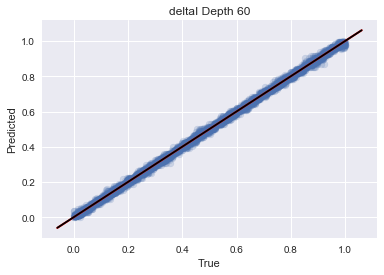

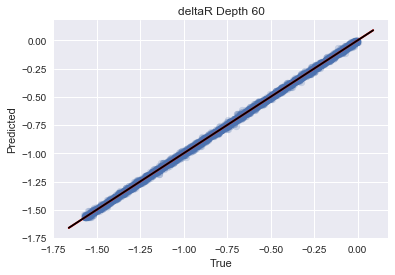

In [13]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X1_train, Y1_train)

#print(data1[data1['Regr - DT']>0.001]) # feature importances 

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X1_test)

#Plot results
plotSummary(Y1_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y1_test['scale factor'], predictions_DT_sp[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [14]:
# spec info decision tree feature importances 
FI_sp_DT = pd.DataFrame(regr_DT_sp.feature_importances_.T, columns = ['Spec - DT'])
FI_sp_DT.index = X1_train.columns

#print(FI_sp_DT[FI_sp_DT['Spec - DT']>0.001])
features_sp_DT = (FI_sp_DT[FI_sp_DT['Spec - DT']>0.006])
features_sp_DT_sorted = features_sp_DT.sort_values('Spec - DT', ascending = False)

### peak info

 
RMSE on test data: 0.014271558931819903 for  deltaI Depth 60
R^2 Score on test data: 0.9975056881231802 for deltaI Depth 60
 
RMSE on test data: 0.023495273439660132 for  deltaR Depth 60
R^2 Score on test data: 0.9973309703228971 for deltaR Depth 60


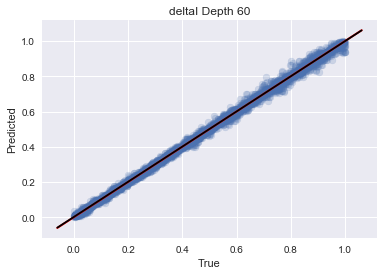

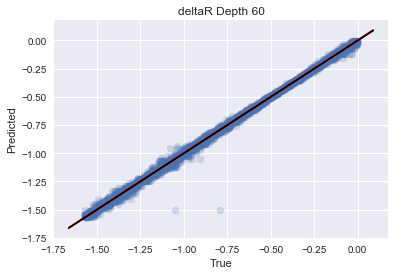

In [15]:
#Initialize the model
rs = 42
regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_pi = regr_DT_pi.predict(X2_test)

#Plot results
plotSummary(Y2_test['deltaI'], predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y2_test['scale factor'], predictions_DT_pi[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [16]:
# peak info decision tree feature importances 
FI_pi_DT = pd.DataFrame(regr_DT_pi.feature_importances_.T, columns = ['Peak - DT'])
FI_pi_DT.index = X2_train.columns

#print(FI_pi_DT[FI_sp_DT['Peak - DT']>0.001])
features_pi_DT = (FI_pi_DT[FI_pi_DT['Peak - DT']>0.006])
features_pi_DT_sorted = features_pi_DT.sort_values('Peak - DT', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.009937878897785283 for  deltaI Depth 60
R^2 Score on test data: 0.9987905293759207 for deltaI Depth 60
 
RMSE on test data: 0.01106098763355895 for  deltaR Depth 60
R^2 Score on test data: 0.9994084653231735 for deltaR Depth 60


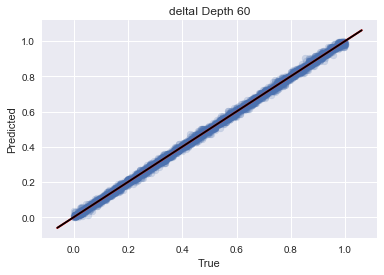

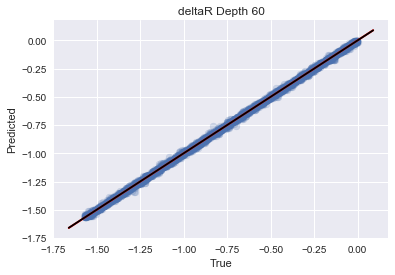

In [17]:
#Initialize the model
rs = 42
regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_both.fit(X_train, Y_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_both = regr_DT_both.predict(X_test)

#Plot results
plotSummary(Y_test['deltaI'], predictions_DT_both[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], predictions_DT_both[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y_test['scale factor'], predictions_DT_both[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [18]:
# combined info decision tree feature importances 
FI_b_DT = pd.DataFrame(regr_DT_both.feature_importances_.T, columns = ['Both - DT'])
FI_b_DT.index = X_train.columns

#print(FI_b_DT[FI_b_DT['Both - DT']>0.001])
features_b_DT = (FI_b_DT[FI_b_DT['Both - DT']>0.006])
features_b_DT_sorted = features_b_DT.sort_values('Both - DT', ascending = False)

In [19]:
display_side_by_side(features_sp_DT_sorted, features_b_DT_sorted, features_pi_DT_sorted,)

,Spec - DT
E_440_mV,0.536616
E_-288_mV,0.113943
E_490_mV,0.103055
E_42_mV,0.063913
E_492_mV,0.035548
E_382_mV,0.033284
E_4_mV,0.008645
E_-220_mV,0.007089
E_-260_mV,0.006961
E_-178_mV,0.006885


## Random Forest

### spec points

 
RMSE on test data: 0.003187468798121657 for  deltaI RF spec
R^2 Score on test data: 0.9998755772463596 for deltaI RF spec
 
RMSE on test data: 0.0033899636963441323 for  deltaR RF spec
R^2 Score on test data: 0.9999444374089635 for deltaR RF spec


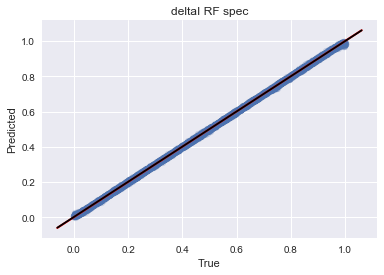

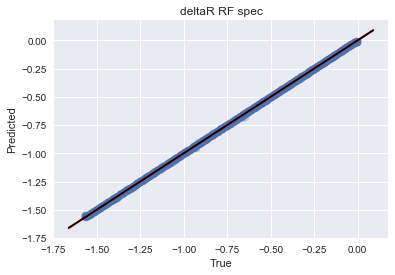

In [20]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI RF spec')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR RF spec')
#plotSummary(Y1_test['scale factor'], predictions_RF_sp[:,2], 'scale factor RF spec')

In [21]:
# spec info random forest feature importances 
FI_sp_RF = pd.DataFrame(regr_RF_sp.feature_importances_.T, columns = ['Spec - RF'])
FI_sp_RF.index = X1_train.columns

#print(FI_sp_RF[FI_sp_RF['Spec - RF']>0.001])
features_sp_RF = (FI_sp_RF[FI_sp_RF['Spec - RF']>0.006])
features_sp_RF_sorted = features_sp_RF.sort_values('Spec - RF', ascending = False)

### peak info

 
RMSE on test data: 0.011764504616204093 for  deltaI RF PI
R^2 Score on test data: 0.9983050565492325 for deltaI RF PI
 
RMSE on test data: 0.01600879785993976 for  deltaR RF PI
R^2 Score on test data: 0.9987608900707452 for deltaR RF PI


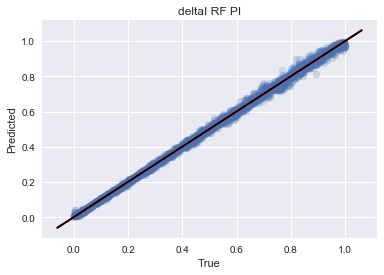

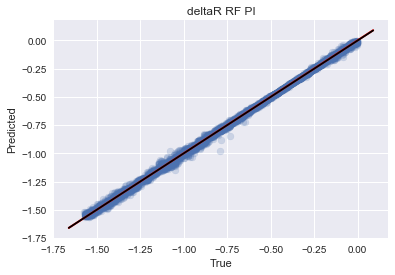

In [22]:
rs = 42
regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_pi = regr_RF_pi.fit(X2_train, Y2_train)

predictions_RF_pi = model_RF_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_RF_pi[:,0], 'deltaI RF PI')
plotSummary(Y2_test['deltaR'], predictions_RF_pi[:,1], 'deltaR RF PI')
#plotSummary(Y2_test['scale factor'], predictions_RF_pi[:,2], 'scale factor RF PI')

In [23]:
# peak info random forest feature importances 
FI_pi_RF = pd.DataFrame(regr_RF_pi.feature_importances_.T, columns = ['Peak - RF'])
FI_pi_RF.index = X2_train.columns

#print(FI_pi_RF[FI_sp_RF['Peak - RF']>0.001])
features_pi_RF = (FI_pi_RF[FI_pi_RF['Peak - RF']>0.006])
features_pi_RF_sorted = features_pi_RF.sort_values('Peak - RF', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.0031858686617340986 for  deltaI RF Combo
R^2 Score on test data: 0.9998757021375599 for deltaI RF Combo
 
RMSE on test data: 0.0035229091788037156 for  deltaR RF Combo
R^2 Score on test data: 0.9999399939154539 for deltaR RF Combo


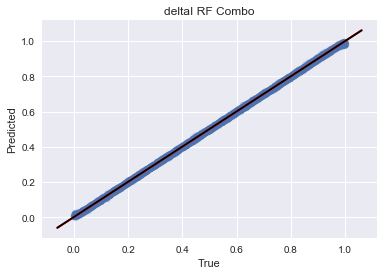

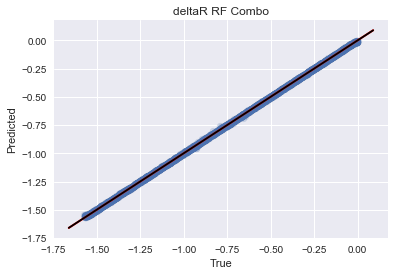

In [24]:
rs = 42
regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_both = regr_RF_both.fit(X_train, Y_train)

predictions_RF_both = model_RF_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_RF_both[:,0], 'deltaI RF Combo')
plotSummary(Y_test['deltaR'], predictions_RF_both[:,1], 'deltaR RF Combo')
#plotSummary(Y_test['scale factor'], predictions_RF_both[:,2], 'scale factor RF Combo')

In [25]:
# combined info decision tree feature importances 
FI_b_RF = pd.DataFrame(regr_RF_both.feature_importances_.T, columns = ['Both - RF'])
FI_b_RF.index = X_train.columns

#print(FI_b_RF[FI_b_RF['Both - RF']>0.001])
features_b_RF = (FI_b_RF[FI_b_RF['Both - RF']>0.006])
features_b_RF_sorted = features_b_RF.sort_values('Both - RF', ascending = False)

In [26]:
display_side_by_side(features_pi_RF_sorted, features_sp_RF_sorted, features_b_RF_sorted)

,Peak - RF
prom4,0.379366
peak4,0.239039
loc4,0.193465
loc2,0.095451
loc3,0.028147
width3,0.014331
peak2,0.011423
prom2,0.011135
width2,0.008994
width4,0.008285


## Independent Random Forests

### spec points


Score - Random Forest: 0.9999812688570825 for deltaR IRF
 
RMSE on test data: 0.0019682757468233144 for  deltaR 10
R^2 Score on test data: 0.9999812688570825 for deltaR 10
 
RMSE on test data: 0.002794241001178301 for  deltaI 10
R^2 Score on test data: 0.9999043828827241 for deltaI 10


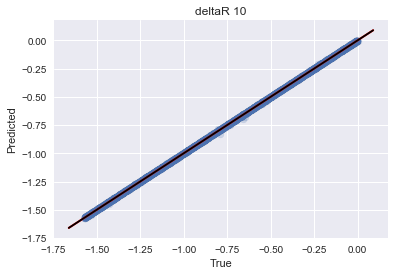

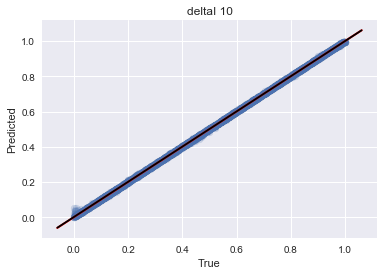

In [27]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
#model_RF2_sf_sp = regr_RF2_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)
#predictions_RF2_sf_sp = model_RF2_sf_sp.predict(X1_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for deltaR IRF')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaR 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaI 10')
#plotSummary(Y1_test['scale factor'], predictions_RF2_sf_sp, 'scale factor IRF')

In [28]:
# spec info independent random forest feature importances delta R  
FI_sp_RF2_dr = pd.DataFrame(model_RF2_dr_sp.feature_importances_.T, columns = ['Spec - RF2_dr'])
FI_sp_RF2_dr.index = X1_train.columns

# print(FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.001])
features_sp_RF2_dr = (FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.006])
features_sp_RF2_dr_sorted = features_sp_RF2_dr.sort_values('Spec - RF2_dr', ascending = False)

# spec info independent random forest feature importances delta I  
FI_sp_RF2_di = pd.DataFrame(model_RF2_di_sp.feature_importances_.T, columns = ['Spec - RF2_di'])
FI_sp_RF2_di.index = X1_train.columns

# print(FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.001])
features_sp_RF2_di = (FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.006])
features_sp_RF2_di_sorted = features_sp_RF2_di.sort_values('Spec - RF2_di', ascending = False)

# spec info independent random forest feature importances scale factor 
#FI_sp_RF2_sf = pd.DataFrame(model_RF2_sf_sp.feature_importances_.T, columns = ['Spec - RF2_sf'])
#FI_sp_RF2_sf.index = X1_train.columns

# print(FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.001])
#features_sp_RF2_sf = (FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.006])
#features_sp_RF2_sf_sorted = features_sp_RF2_sf.sort_values('Spec - RF2_sf', ascending = False)

### peak info


Score - Random Forest: 0.9985907621336887 for delta R IRF PI
 
RMSE on test data: 0.017072454126642954 for  deltaI IRF PI
R^2 Score on test data: 0.9985907621336887 for deltaI IRF PI
 
RMSE on test data: 0.011907707138732664 for  deltaR IRF PI
R^2 Score on test data: 0.998263542276944 for deltaR IRF PI


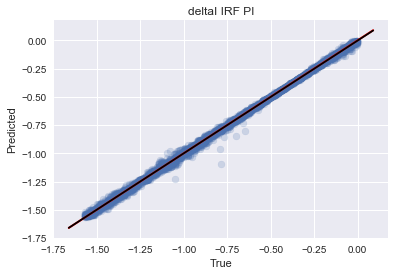

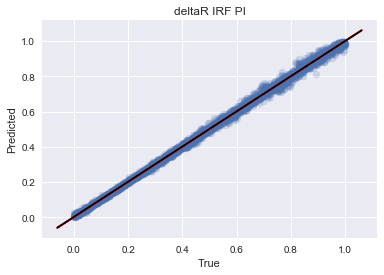

In [29]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_pi = regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_RF2_di_pi = regr_RF2_di_pi.fit(X2_train, Y2_train['deltaI'])
#model_RF2_sf_pi = regr_RF2_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_RF2_dr_pi = model_RF2_dr_pi.predict(X2_test)
predictions_RF2_di_pi = model_RF2_di_pi.predict(X2_test)
#predictions_RF2_sf_pi = model_RF2_sf_pi.predict(X2_test)


#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_pi.score(X2_test, Y2_test['deltaR']), 'for delta R IRF PI')

plotSummary(Y2_test['deltaR'], predictions_RF2_dr_pi, 'deltaI IRF PI')
plotSummary(Y2_test['deltaI'], predictions_RF2_di_pi, 'deltaR IRF PI')
#plotSummary(Y2_test['scale factor'], predictions_RF2_sf_pi, 'scale factor IRF PI')

In [30]:
# peak info independent random forest feature importances delta R  
FI_pi_RF2_dr = pd.DataFrame(model_RF2_dr_pi.feature_importances_.T, columns = ['Peak - RF2_dr'])
FI_pi_RF2_dr.index = X2_train.columns

# print(FI_pi_RF2_dr[FI_pi_RF2_dr['Peak - RF2_dr']>0.001])
features_pi_RF2_dr = (FI_pi_RF2_dr[FI_pi_RF2_dr['Peak - RF2_dr']>0.006])
features_pi_RF2_dr_sorted = features_pi_RF2_dr.sort_values('Peak - RF2_dr', ascending = False)


# peak info independent random forest feature importances delta I 
FI_pi_RF2_di = pd.DataFrame(model_RF2_di_pi.feature_importances_.T, columns = ['Peak - RF2_di'])
FI_pi_RF2_di.index = X2_train.columns

# print(FI_pi_RF2_di[FI_pi_RF2_di['Peak - RF2_di']>0.001])
features_pi_RF2_di = (FI_pi_RF2_di[FI_pi_RF2_di['Peak - RF2_di']>0.006])
features_pi_RF2_di_sorted = features_pi_RF2_di.sort_values('Peak - RF2_di', ascending = False)

# peak info independent random forest feature importances scale factor
#FI_pi_RF2_sf = pd.DataFrame(model_RF2_sf_pi.feature_importances_.T, columns = ['Peak - RF2_sf'])
#FI_pi_RF2_sf.index = X2_train.columns

# print(FI_pi_RF2_sf[FI_pi_RF2_sf['Peak - RF2_sf']>0.001])
#features_pi_RF2_sf = (FI_pi_RF2_sf[FI_pi_RF2_sf['Peak - RF2_sf']>0.006])
#features_pi_RF2_sf_sorted = features_pi_RF2_sf.sort_values('Peak - RF2_sf', ascending = False)


### spec points and peak info


Score - Random Forest: 0.9999811064801011 for delta R IRF Both
 
RMSE on test data: 0.001976788655432207 for  deltaI 10
R^2 Score on test data: 0.9999811064801011 for deltaI 10
 
RMSE on test data: 0.0027918127890070865 for  deltaR 10
R^2 Score on test data: 0.9999045489942123 for deltaR 10


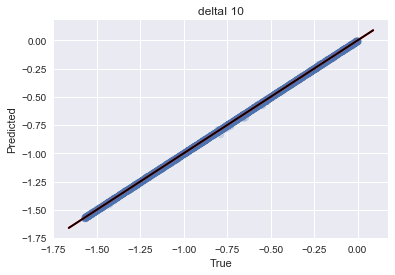

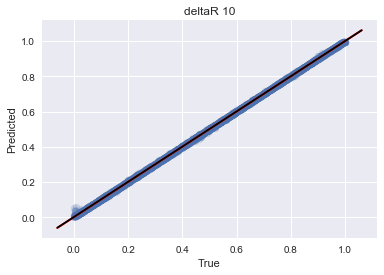

In [31]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_both = regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])
model_RF2_di_both = regr_RF2_di_both.fit(X_train, Y_train['deltaI'])
#model_RF2_sf_both = regr_RF2_sf_both.fit(X_train, Y_train['scale factor'])

predictions_RF2_dr_both = model_RF2_dr_both.predict(X_test)
predictions_RF2_di_both = model_RF2_di_both.predict(X_test)
#predictions_RF2_sf_both = model_RF2_sf_both.predict(X_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_both.score(X_test, Y_test['deltaR']), 'for delta R IRF Both')

plotSummary(Y_test['deltaR'], predictions_RF2_dr_both, 'deltaI 10')
plotSummary(Y_test['deltaI'], predictions_RF2_di_both, 'deltaR 10')
#plotSummary(Y_test['scale factor'], predictions_RF2_sf_both, 'deltaR IRF Both')

In [32]:
# combined info independent random forest feature importances delta R  
FI_b_RF2_dr = pd.DataFrame(model_RF2_dr_both.feature_importances_.T, columns = ['Both - RF2_dr'])
FI_b_RF2_dr.index = X_train.columns

# print(FI_b_RF2_dr[FI_b_RF2_dr['Both - RF2_dr']>0.001])
features_b_RF2_dr = (FI_b_RF2_dr[FI_b_RF2_dr['Both - RF2_dr']>0.006])
features_b_RF2_dr_sorted = features_b_RF2_dr.sort_values('Both - RF2_dr', ascending = False)


# combined info independent random forest feature importances delta I  
FI_b_RF2_di = pd.DataFrame(model_RF2_di_both.feature_importances_.T, columns = ['Both - RF2_di'])
FI_b_RF2_di.index = X_train.columns

# print(FI_b_RF2_di[FI_b_RF2_di['Both - RF2_di']>0.001])
features_b_RF2_di = (FI_b_RF2_di[FI_b_RF2_di['Both - RF2_di']>0.006])
features_b_RF2_di_sorted = features_b_RF2_di.sort_values('Both - RF2_di', ascending = False)

# combined info independent random forest feature importances scale factor 
#FI_b_RF2_sf = pd.DataFrame(model_RF2_sf_both.feature_importances_.T, columns = ['Both - RF2_sf'])
#FI_b_RF2_sf.index = X_train.columns

# print(FI_b_RF2_sf[FI_b_RF2_sf['Both - RF2_sf']>0.001])
#features_b_RF2_sf = (FI_b_RF2_sf[FI_b_RF2_sf['Both - RF2_sf']>0.006])
#features_b_RF2_sf_sorted = features_b_RF2_sf.sort_values('Both - RF2_sf', ascending = False)

In [33]:

#display_side_by_side(features_sp_RF2_dr_sorted, features_sp_RF2_di_sorted, features_sp_RF2_sf_sorted, features_b_RF2_dr_sorted, features_b_RF2_di_sorted, features_b_RF2_sf_sorted)
#display_side_by_side(features_pi_RF2_dr_sorted, features_pi_RF2_di_sorted, features_pi_RF2_sf_sorted)

display_side_by_side(features_sp_RF2_dr_sorted, features_sp_RF2_di_sorted,  features_b_RF2_dr_sorted, features_b_RF2_di_sorted)
display_side_by_side(features_pi_RF2_dr_sorted, features_pi_RF2_di_sorted)

,Spec - RF2_dr
E_442_mV,0.375657
E_440_mV,0.300612
E_404_mV,0.096876
E_44_mV,0.033726
E_-162_mV,0.025869
E_42_mV,0.025501
E_-16_mV,0.025183
E_444_mV,0.025020
E_438_mV,0.024766
E_116_mV,0.010893


,Peak - RF2_dr
prom4,0.394934
peak4,0.266471
loc4,0.209091
width4,0.042649
loc2,0.038849
loc3,0.023526
width3,0.010824
width2,0.007843
,Peak - RF2_di
width2,0.531298


## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.0026226095375828534 for  AdaBoost Delta I SP
R^2 Score on test data: 0.9999157683715907 for AdaBoost Delta I SP
 
RMSE on test data: 0.002273330961402347 for  AdaBoost Delta R SP
R^2 Score on test data: 0.9999750127921785 for AdaBoost Delta R SP
Delta I AdaBoost Score: 0.9999157683715908
Delta R AdaBoost Score: 0.9999750127921786


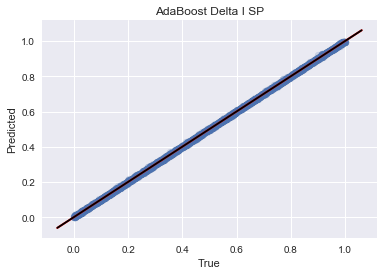

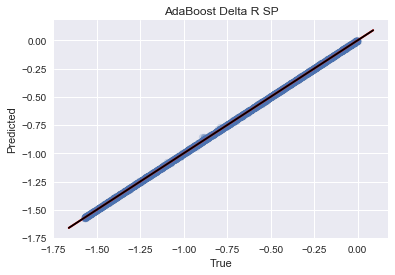

In [34]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_AB_sf_sp = regr_AB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)
#predictions_AB_sf_sp = model_AB_sf_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_AB_sf_sp, 'AdaBoost Scale Factor SP')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))
#print('Scale Factor AdaBoost Score:', model_AB_sf_sp.score(X1_test, Y1_test['scale factor']))


In [35]:
# spec info adaboost random forest feature importances delta R  
FI_sp_AB_dr = pd.DataFrame(model_AB_dr_sp.feature_importances_.T, columns = ['Spec - AB_dr'])
FI_sp_AB_dr.index = X1_train.columns

# print(FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.001])
features_sp_AB_dr = (FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.006])
features_sp_AB_dr_sorted = features_sp_AB_dr.sort_values('Spec - AB_dr', ascending = False)

# spec info adaboost random forest feature importances delta I  
FI_sp_AB_di = pd.DataFrame(model_AB_di_sp.feature_importances_.T, columns = ['Spec - AB_di'])
FI_sp_AB_di.index = X1_train.columns

# print(FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.001])
features_sp_AB_di = (FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.006])
features_sp_AB_di_sorted = features_sp_AB_di.sort_values('Spec - AB_di', ascending = False)

# spec info adaboost random forest feature importances scale factor 
#FI_sp_AB_sf = pd.DataFrame(model_AB_sf_sp.feature_importances_.T, columns = ['Spec - AB_sf'])
#FI_sp_AB_sf.index = X1_train.columns

# print(FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.001])
#features_sp_AB_sf = (FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.006])
#features_sp_AB_sf_sorted = features_sp_AB_sf.sort_values('Spec - AB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.012705315207951633 for  AdaBoost Delta I PI
R^2 Score on test data: 0.9980231268072299 for AdaBoost Delta I PI
 
RMSE on test data: 0.0171084188807258 for  AdaBoost Delta R PI
R^2 Score on test data: 0.9985848184917137 for AdaBoost Delta R PI


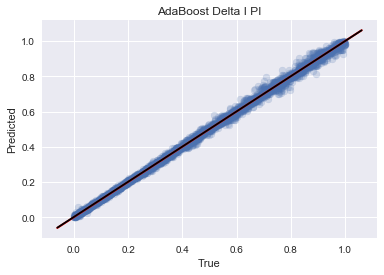

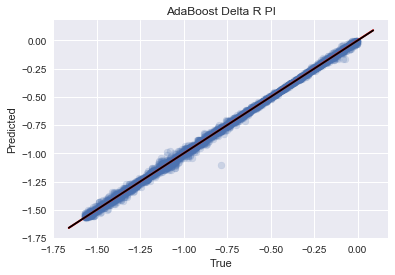

In [36]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_pi = regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_AB_dr_pi = regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])
#model_AB_sf_pi = regr_AB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_AB_di_pi = model_AB_di_pi.predict(X2_test)
predictions_AB_dr_pi = model_AB_dr_pi.predict(X2_test)
#predictions_AB_sf_pi = model_AB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_AB_di_pi, 'AdaBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_AB_dr_pi, 'AdaBoost Delta R PI')
#plotSummary(Y2_test['scale factor'], predictions_AB_sf_pi, 'AdaBoost Scale Factor PI')

In [37]:
# peak info adaboost random forest feature importances delta R  
FI_pi_AB_dr = pd.DataFrame(model_AB_dr_pi.feature_importances_.T, columns = ['Peak - AB_dr'])
FI_pi_AB_dr.index = X2_train.columns

# print(FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.001])
features_pi_AB_dr = (FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.006])
features_pi_AB_dr_sorted = features_pi_AB_dr.sort_values('Peak - AB_dr', ascending = False)


# peak info adaboost random forest feature importances delta I 
FI_pi_AB_di = pd.DataFrame(model_AB_di_pi.feature_importances_.T, columns = ['Peak - AB_di'])
FI_pi_AB_di.index = X2_train.columns

# print(FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.001])
features_pi_AB_di = (FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.006])
features_pi_AB_di_sorted = features_pi_AB_di.sort_values('Peak - AB_di', ascending = False)

# peak info adaboost random forest feature importances scale factor
#FI_pi_AB_sf = pd.DataFrame(model_AB_sf_pi.feature_importances_.T, columns = ['Peak - AB_sf'])
#FI_pi_AB_sf.index = X2_train.columns

# print(FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.001])
#features_pi_AB_sf = (FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.006])
#features_pi_AB_sf_sorted = features_pi_AB_sf.sort_values('Peak - AB_sf', ascending = False)


### spec points and peak info

 
RMSE on test data: 0.002877668635158595 for  AdaBoost Delta I Combo
R^2 Score on test data: 0.9998985879665979 for AdaBoost Delta I Combo
 
RMSE on test data: 0.002264144903747007 for  AdaBoost Delta R Combo
R^2 Score on test data: 0.9999752143204084 for AdaBoost Delta R Combo


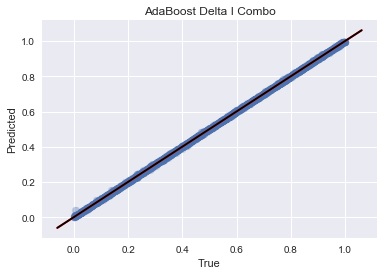

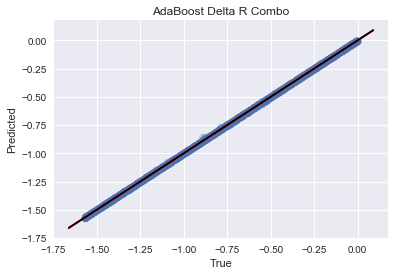

In [38]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_both = regr_AB_di_both.fit(X_train, Y_train['deltaI'])
model_AB_dr_both = regr_AB_dr_both.fit(X_train, Y_train['deltaR'])
#model_AB_sf_both = regr_AB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_AB_di_both = model_AB_di_both.predict(X_test)
predictions_AB_dr_both = model_AB_dr_both.predict(X_test)
#predictions_AB_sf_both = model_AB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_AB_di_both, 'AdaBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_AB_dr_both, 'AdaBoost Delta R Combo')
#plotSummary(Y_test['scale factor'], predictions_AB_sf_both, 'AdaBoost Scale Factor Combo')

In [39]:
# combined info adaboost random forest feature importances delta R  
FI_b_AB_dr = pd.DataFrame(model_AB_dr_both.feature_importances_.T, columns = ['Both - AB_dr'])
FI_b_AB_dr.index = X_train.columns

# print(FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.001])
features_b_AB_dr = (FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.006])
features_b_AB_dr_sorted = features_b_AB_dr.sort_values('Both - AB_dr', ascending = False)


# combined info adaboost random forest feature importances delta I  
FI_b_AB_di = pd.DataFrame(model_AB_di_both.feature_importances_.T, columns = ['Both - AB_di'])
FI_b_AB_di.index = X_train.columns

# print(FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.001])
features_b_AB_di = (FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.006])
features_b_AB_di_sorted = features_b_AB_di.sort_values('Both - AB_di', ascending = False)

# combined info adaboost random forest feature importances scale factor 
#FI_b_AB_sf = pd.DataFrame(model_AB_sf_both.feature_importances_.T, columns = ['Both - AB_sf'])
#FI_b_AB_sf.index = X_train.columns

# print(FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.001])
#features_b_AB_sf = (FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.006])
#features_b_AB_sf_sorted = features_b_AB_sf.sort_values('Both - AB_sf', ascending = False)

In [40]:
#display_side_by_side(features_sp_AB_dr_sorted, features_sp_AB_di_sorted, features_sp_AB_sf_sorted, features_b_AB_dr_sorted, features_b_AB_di_sorted, features_b_AB_sf_sorted)
#display_side_by_side(features_pi_AB_dr_sorted, features_pi_AB_di_sorted, features_pi_AB_sf_sorted)

display_side_by_side(features_sp_AB_dr_sorted, features_sp_AB_di_sorted, features_b_AB_dr_sorted, features_b_AB_di_sorted)
display_side_by_side(features_pi_AB_dr_sorted, features_pi_AB_di_sorted)

,Spec - AB_dr
E_442_mV,0.234472
E_444_mV,0.154362
E_440_mV,0.141778
E_-16_mV,0.092386
E_404_mV,0.055115
E_436_mV,0.052357
E_-206_mV,0.042664
E_402_mV,0.038513
E_46_mV,0.027829
E_42_mV,0.024168


,Peak - AB_dr
prom4,0.464994
loc4,0.230956
peak4,0.195019
width4,0.039169
loc2,0.030378
loc3,0.012390
width3,0.010475
width2,0.006809
,Peak - AB_di
width2,0.536763


## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.013131240114795432 for  GradientBoost Delta I SP
R^2 Score on test data: 0.9978883622862641 for GradientBoost Delta I SP
 
RMSE on test data: 0.019477364803176547 for  GradientBoost Delta R SP
R^2 Score on test data: 0.9981657742237077 for GradientBoost Delta R SP


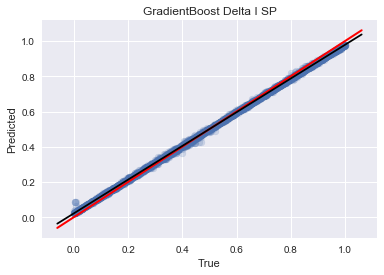

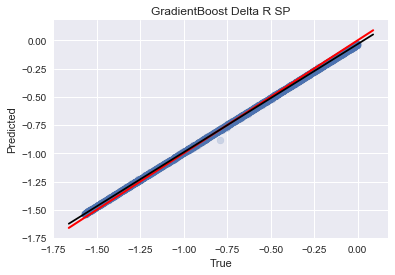

In [41]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_GB_sf_sp = regr_GB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)
#predictions_GB_sf_sp = model_GB_sf_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_GB_sf_sp, 'GradientBoost Scale Factor SP')

In [42]:
# spec info gradientboost random forest feature importances delta R  
FI_sp_GB_dr = pd.DataFrame(model_GB_dr_sp.feature_importances_.T, columns = ['Spec - GB_dr'])
FI_sp_GB_dr.index = X1_train.columns

# print(FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.001])
features_sp_GB_dr = (FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.006])
features_sp_GB_dr_sorted = features_sp_GB_dr.sort_values('Spec - GB_dr', ascending = False)

# spec info gradientboost random forest feature importances delta I  
FI_sp_GB_di = pd.DataFrame(model_GB_di_sp.feature_importances_.T, columns = ['Spec - GB_di'])
FI_sp_GB_di.index = X1_train.columns

# print(FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.001])
features_sp_GB_di = (FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.006])
features_sp_GB_di_sorted = features_sp_GB_di.sort_values('Spec - GB_di', ascending = False)

# spec info gradientboost random forest feature importances scale factor   
#FI_sp_GB_sf = pd.DataFrame(model_GB_sf_sp.feature_importances_.T, columns = ['Spec - GB_sf'])
#FI_sp_GB_sf.index = X1_train.columns

# print(FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.001])
#features_sp_GB_sf = (FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.006])
#features_sp_GB_sf_sorted = features_sp_GB_sf.sort_values('Spec - GB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.018018018710604967 for  GradientBoost Delta I PI
R^2 Score on test data: 0.996024223234231 for GradientBoost Delta I PI
 
RMSE on test data: 0.026273857258638372 for  GradientBoost Delta R PI
R^2 Score on test data: 0.9966623555735761 for GradientBoost Delta R PI


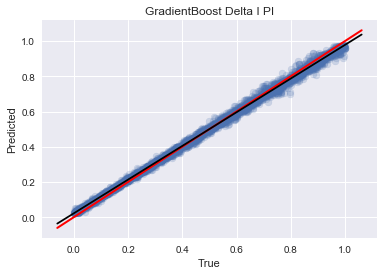

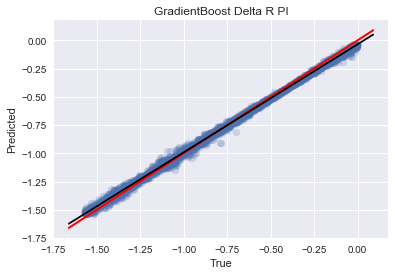

In [43]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_pi = regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_GB_dr_pi = regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])
#model_GB_sf_pi = regr_GB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_GB_di_pi = model_GB_di_pi.predict(X2_test)
predictions_GB_dr_pi = model_GB_dr_pi.predict(X2_test)
#predictions_GB_sf_pi = model_GB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_GB_di_pi, 'GradientBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_GB_dr_pi, 'GradientBoost Delta R PI')
#plotSummary(Y2_test['scale factor'], predictions_GB_sf_pi, 'GradientBoost Scale Factor PI')

In [44]:
# peak info gradient boost random forest feature importances delta R  
FI_pi_GB_dr = pd.DataFrame(model_GB_dr_pi.feature_importances_.T, columns = ['Peak - GB_dr'])
FI_pi_GB_dr.index = X2_train.columns

# print(FI_pi_GB_dr[FI_pi_AB_dr['Peak - GB_dr']>0.001])
features_pi_GB_dr = (FI_pi_GB_dr[FI_pi_GB_dr['Peak - GB_dr']>0.006])
features_pi_GB_dr_sorted = features_pi_GB_dr.sort_values('Peak - GB_dr', ascending = False)


# peak info gradientboost random forest feature importances delta I 
FI_pi_GB_di = pd.DataFrame(model_GB_di_pi.feature_importances_.T, columns = ['Peak - GB_di'])
FI_pi_GB_di.index = X2_train.columns

# print(FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.001])
features_pi_GB_di = (FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.006])
features_pi_GB_di_sorted = features_pi_GB_di.sort_values('Peak - GB_di', ascending = False)


# peak info gradientboost random forest feature importances scale factor
#FI_pi_GB_sf = pd.DataFrame(model_GB_sf_pi.feature_importances_.T, columns = ['Peak - GB_sf'])
#FI_pi_GB_sf.index = X2_train.columns

# print(FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.001])
#features_pi_GB_sf = (FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.006])
#features_pi_GB_sf_sorted = features_pi_GB_sf.sort_values('Peak - GB_sf', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.013202196595931056 for  GradientBoost Delta I Combo
R^2 Score on test data: 0.9978654795721046 for GradientBoost Delta I Combo
 
RMSE on test data: 0.019488590413814403 for  GradientBoost Delta R Combo
R^2 Score on test data: 0.9981636593341302 for GradientBoost Delta R Combo


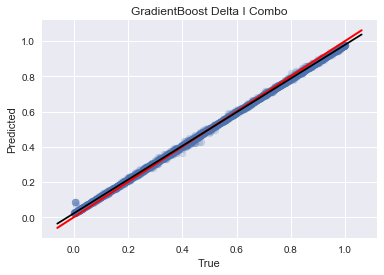

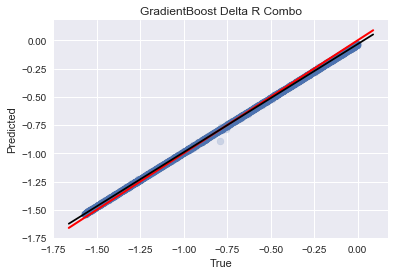

In [45]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_both = regr_GB_di_both.fit(X_train, Y_train['deltaI'])
model_GB_dr_both = regr_GB_dr_both.fit(X_train, Y_train['deltaR'])
#model_GB_sf_both = regr_GB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_GB_di_both = model_GB_di_both.predict(X_test)
predictions_GB_dr_both = model_GB_dr_both.predict(X_test)
#predictions_GB_sf_both = model_GB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_GB_di_both, 'GradientBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_GB_dr_both, 'GradientBoost Delta R Combo')
#plotSummary(Y_test['scale factor'], predictions_GB_sf_both, 'GradientBoost Scale Factor Combo')


In [46]:
# combined info gradient boost random forest feature importances delta R  
FI_b_GB_dr = pd.DataFrame(model_GB_dr_both.feature_importances_.T, columns = ['Both - GB_dr'])
FI_b_GB_dr.index = X_train.columns

# print(FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.001])
features_b_GB_dr = (FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.006])
features_b_GB_dr_sorted = features_b_GB_dr.sort_values('Both - GB_dr', ascending = False)


# combined info gradient boost random forest feature importances delta I  
FI_b_GB_di = pd.DataFrame(model_GB_di_both.feature_importances_.T, columns = ['Both - GB_di'])
FI_b_GB_di.index = X_train.columns

# print(FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.001])
features_b_GB_di = (FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.006])
features_b_GB_di_sorted = features_b_GB_di.sort_values('Both - GB_di', ascending = False)

# combined info gradient boost random forest feature importances scale factor 
#FI_b_GB_sf = pd.DataFrame(model_GB_sf_both.feature_importances_.T, columns = ['Both - GB_sf'])
#FI_b_GB_sf.index = X_train.columns

# print(FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.001])
#features_b_GB_sf = (FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.006])
#features_b_GB_sf_sorted = features_b_GB_sf.sort_values('Both - GB_sf', ascending = False)

In [47]:
#display_side_by_side(features_sp_GB_dr_sorted, features_sp_GB_di_sorted,features_sp_GB_sf_sorted, features_b_GB_dr_sorted, features_b_GB_di_sorted, features_b_GB_sf_sorted)
#display_side_by_side(features_pi_GB_dr_sorted, features_pi_GB_di_sorted, features_pi_GB_sf_sorted)

display_side_by_side(features_sp_GB_dr_sorted, features_sp_GB_di_sorted, features_b_GB_dr_sorted, features_b_GB_di_sorted)
display_side_by_side(features_pi_GB_dr_sorted, features_pi_GB_di_sorted)

,Spec - GB_dr
E_442_mV,0.751183
E_404_mV,0.097314
E_-162_mV,0.082200
E_116_mV,0.012262
E_276_mV,0.011356
E_-128_mV,0.011322
E_24_mV,0.010687
,Spec - GB_di
E_-188_mV,0.536446
E_408_mV,0.152916


,Peak - GB_dr
prom4,0.631197
loc4,0.215274
loc2,0.053012
width4,0.049835
peak4,0.030194
width2,0.007035
,Peak - GB_di
width2,0.514761
loc3,0.338257
width3,0.058130


In [48]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_dr_sorted,features_sp_AB_dr_sorted,features_sp_RF2_dr_sorted)

,Spec - RF
E_442_mV,0.250551
E_440_mV,0.143576
E_-288_mV,0.072193
E_-16_mV,0.071561
E_438_mV,0.053406
E_490_mV,0.037035
E_492_mV,0.036283
E_226_mV,0.020639
E_364_mV,0.017939
E_-200_mV,0.013290


In [49]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_di_sorted,features_sp_AB_di_sorted,features_sp_RF2_di_sorted)

,Spec - RF
E_442_mV,0.250551
E_440_mV,0.143576
E_-288_mV,0.072193
E_-16_mV,0.071561
E_438_mV,0.053406
E_490_mV,0.037035
E_492_mV,0.036283
E_226_mV,0.020639
E_364_mV,0.017939
E_-200_mV,0.013290


In [50]:
#display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_sf_sorted,features_sp_AB_sf_sorted,features_sp_RF2_sf_sorted)

In [51]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_dr_sorted,features_pi_AB_dr_sorted,features_pi_RF2_dr_sorted)

,Peak - RF
prom4,0.379366
peak4,0.239039
loc4,0.193465
loc2,0.095451
loc3,0.028147
width3,0.014331
peak2,0.011423
prom2,0.011135
width2,0.008994
width4,0.008285


In [52]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_di_sorted,features_pi_AB_di_sorted,features_pi_RF2_di_sorted)

,Peak - RF
prom4,0.379366
peak4,0.239039
loc4,0.193465
loc2,0.095451
loc3,0.028147
width3,0.014331
peak2,0.011423
prom2,0.011135
width2,0.008994
width4,0.008285


In [53]:
#display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_sf_sorted,features_pi_AB_sf_sorted,features_pi_RF2_sf_sorted)

In [54]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_dr_sorted,features_b_AB_dr_sorted,features_b_RF2_dr_sorted)

,Both - RF
E_442_mV,0.250580
E_440_mV,0.143559
E_-288_mV,0.072110
E_-16_mV,0.071567
E_438_mV,0.053355
E_490_mV,0.036745
E_492_mV,0.036357
E_226_mV,0.020534
E_364_mV,0.017884
E_40_mV,0.014569


In [55]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_di_sorted,features_b_AB_di_sorted,features_b_RF2_di_sorted)

,Both - RF
E_442_mV,0.250580
E_440_mV,0.143559
E_-288_mV,0.072110
E_-16_mV,0.071567
E_438_mV,0.053355
E_490_mV,0.036745
E_492_mV,0.036357
E_226_mV,0.020534
E_364_mV,0.017884
E_40_mV,0.014569


In [56]:
#display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_sf_sorted,features_b_AB_sf_sorted,features_b_RF2_sf_sorted)

## Testing the Models on the Experimental Data



In [57]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names
col_names_exp_both = col_names_both[2:]

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_peakinfo.csv', header = None, names = col_names3)

In [58]:
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
col_names1a = energy_names[50:] # use for taking out first peak specs 
exp_data_sp = exp_data_sp[col_names1a] # use for taking out first peak specs 
exp_data_sp

,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,E_-286_mV,E_-284_mV,E_-282_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.63866,0.64322,0.6455,0.6487,0.65752,0.66493,0.67365,0.68098,0.69691,0.70971,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [59]:
## Use these if want to remove first peak info
peak_names2 = ['peak2', 'peak3', 'peak4']
prom_names2 = ['prom2', 'prom3', 'prom4']
locs_names2 = ['loc2', 'loc3', 'loc4']
width_names2 = ['width2', 'width3', 'width4']
pi_names = peak_names2 + locs_names2 + width_names2 + prom_names2
exp_data_pi = exp_data_pi[pi_names]
exp_data_pi

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,prom3,prom4
0,1.9262,1.8662,1.4495,-0.242,-0.074,0.134,0.032045,0.039422,0.04612,1.2902,1.1855,0.57098


In [60]:
# Use these if want to remove first peak info 
#subset = 5 
energy_names2 = energy_names[50:]
exp_data_sp2 = exp_data_sp[energy_names2]
exp_data_both = exp_data_pi.join(exp_data_sp2, how = 'left')
exp_data_both = exp_data_pi.join(exp_data_sp, how = 'left')
exp_data_both


,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,1.9262,1.8662,1.4495,-0.242,-0.074,0.134,0.032045,0.039422,0.04612,1.2902,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [61]:
pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
 #                            r2_score(Y1_test['scale factor'], predictions_DT_sp[:,2])).reshape(6,1).T

pred_phase_DT_pi = np.append(regr_DT_pi.predict(exp_data_pi), 
                            r2_score(Y1_test['deltaI'], predictions_DT_pi[:,0])).reshape(3,1).T
pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            r2_score(Y1_test['deltaR'], predictions_DT_pi[:,1])).reshape(4,1).T
#pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
 #                           r2_score(Y1_test['scale factor'], predictions_DT_pi[:,2])).reshape(6,1).T

pred_phase_DT_both = np.append(regr_DT_both.predict(exp_data_both), 
                            r2_score(Y_test['deltaI'], predictions_DT_both[:,0])).reshape(3,1).T
pred_phase_DT_both = np.append(pred_phase_DT_both, 
                            r2_score(Y_test['deltaR'], predictions_DT_both[:,1])).reshape(4,1).T
#pred_phase_DT_both = np.append(pred_phase_DT_both, 
 #                           r2_score(Y_test['scale factor'], predictions_DT_both[:,2])).reshape(6,1).T

In [62]:
pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)
pred_phase_RF_pi = regr_RF_pi.predict(exp_data_pi)
pred_phase_RF_both = regr_RF_both.predict(exp_data_both)

pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)
#pred_phase_AB_sf_sp = model_AB_sf_sp.predict(exp_data_sp)

pred_phase_AB_R_pi = model_AB_dr_pi.predict(exp_data_pi)
pred_phase_AB_I_pi = model_AB_di_pi.predict(exp_data_pi)
#pred_phase_AB_sf_pi = model_AB_sf_pi.predict(exp_data_pi)

pred_phase_AB_R_both = model_AB_dr_both.predict(exp_data_both)
pred_phase_AB_I_both = model_AB_di_both.predict(exp_data_both)
#pred_phase_AB_sf_both = model_AB_sf_both.predict(exp_data_both)

pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)
#pred_phase_GB_sf_sp = model_GB_sf_sp.predict(exp_data_sp)

pred_phase_GB_di_pi = model_GB_di_pi.predict(exp_data_pi)
pred_phase_GB_dr_pi = model_GB_dr_pi.predict(exp_data_pi)
#pred_phase_GB_sf_pi = model_GB_sf_pi.predict(exp_data_pi)

pred_phase_GB_di_both = model_GB_di_both.predict(exp_data_both)
pred_phase_GB_dr_both = model_GB_dr_both.predict(exp_data_both)
#pred_phase_GB_sf_both = model_GB_sf_both.predict(exp_data_both)

pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)
#pred_phase_IRF_sf_sp = model_RF2_sf_sp.predict(exp_data_sp)

pred_phase_IRF_di_pi = model_RF2_di_pi.predict(exp_data_pi)
pred_phase_IRF_dr_pi = model_RF2_dr_pi.predict(exp_data_pi)
#pred_phase_IRF_sf_pi = model_RF2_sf_pi.predict(exp_data_pi)

pred_phase_IRF_di_both = model_RF2_di_both.predict(exp_data_both)
pred_phase_IRF_dr_both = model_RF2_dr_both.predict(exp_data_both)
#pred_phase_IRF_sf_both = model_RF2_sf_both.predict(exp_data_both)


In [63]:
#predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score', 'scale factor', 'scale factor score'], index = ['Decision Tree spec points'])

predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], index = ['Decision Tree spec points'])




In [64]:
#new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree peak info')
#predictedPhases = predictedPhases.append(new_test)

new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], name = 'Decision Tree peak info')
predictedPhases = predictedPhases.append(new_test)

In [65]:
#new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree spec points and peak info')
#predictedPhases = predictedPhases.append(new_1)

new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR',  'deltaI score', 'deltaR score'], name = 'Decision Tree spec points and peak info')
predictedPhases = predictedPhases.append(new_1)

In [66]:
RF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0])
RF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1])
#RF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_sp[:,2])

RF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_pi[:,0])
RF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_pi[:,1])
#RF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_pi[:,2])

RF_b_di_r2score = r2_score(Y_test['deltaI'], predictions_RF_both[:,0])
RF_b_dr_r2score = r2_score(Y_test['deltaR'], predictions_RF_both[:,1])
#RF_b_sf_r2score = r2_score(Y_test['scale factor'], predictions_RF_both[:,2])

In [67]:
#predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], pred_phase_RF_sp[0,2], RF_sp_di_r2score, RF_sp_dr_r2score, RF_sp_sf_r2score)
#predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], pred_phase_RF_pi[0,2], RF_pi_di_r2score, RF_pi_dr_r2score, RF_pi_sf_r2score )
#predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], pred_phase_RF_both[0,2], RF_b_di_r2score, RF_b_dr_r2score, RF_b_sf_r2score)

predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], RF_sp_di_r2score, RF_sp_dr_r2score)
predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], RF_pi_di_r2score, RF_pi_dr_r2score )
predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], RF_b_di_r2score, RF_b_dr_r2score)

In [68]:
AB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_sp)
AB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_sp)
#AB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_sp)

AB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_pi)
AB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_pi)
#AB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_pi)

AB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_both)
AB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_both)
#AB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_both)

In [69]:
#predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], pred_phase_AB_sf_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score, AB_sp_sf_r2score)
#predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0], pred_phase_AB_sf_pi[0], AB_pi_di_r2score, AB_pi_dr_r2score, AB_pi_sf_r2score) 
#predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0], pred_phase_AB_sf_both[0], AB_b_di_r2score, AB_b_dr_r2score, AB_b_sf_r2score)



predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0],  AB_sp_di_r2score, AB_sp_dr_r2score)
predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0], AB_pi_di_r2score, AB_pi_dr_r2score) 
predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0],  AB_b_di_r2score, AB_b_dr_r2score)

In [70]:
GB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_sp)
GB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_sp)
#GB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_sp)

GB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_pi)
GB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_pi)
#GB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_pi)

GB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_both)
GB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_both)
#GB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_both)

In [71]:
#predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], pred_phase_GB_sf_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score, GB_sp_sf_r2score)
#predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0], pred_phase_GB_sf_pi[0], GB_pi_di_r2score, GB_pi_dr_r2score, GB_pi_sf_r2score) 
#predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], pred_phase_GB_dr_both[0], pred_phase_GB_sf_both[0], GB_b_di_r2score, GB_b_dr_r2score, GB_b_sf_r2score)


predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score)
predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0],  GB_pi_di_r2score, GB_pi_dr_r2score) 
predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], GB_b_di_r2score, GB_b_dr_r2score, GB_b_di_r2score)

In [72]:
IRF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_sp)
IRF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp)
#IRF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_sp)

IRF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_pi)
IRF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_pi)
#IRF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_pi)

IRF_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_both)
IRF_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_both)
#IRF_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_both)

In [73]:
#predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  pred_phase_IRF_sf_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score, IRF_sp_sf_r2score)
#predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0],  pred_phase_IRF_sf_pi[0], IRF_pi_di_r2score, IRF_pi_dr_r2score, IRF_pi_sf_r2score)
#predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0],  pred_phase_IRF_sf_both[0], IRF_b_di_r2score, IRF_b_dr_r2score, IRF_b_sf_r2score)


predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score)
predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0],  IRF_pi_di_r2score, IRF_pi_dr_r2score)
predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0],   IRF_b_di_r2score, IRF_b_dr_r2score)

In [74]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,0.009015,-0.071768,0.998783,0.999452
Decision Tree peak info,0.015697,-0.154510,0.997506,0.997331
Decision Tree spec points and peak info,0.009015,-0.071768,0.998791,0.999408
Random Forest spec points,0.021063,-0.084981,0.999876,0.999944
Random Forest peak info,0.019009,-0.169336,0.998305,0.998761
Random Forest spec points and peak info,0.023803,-0.097531,0.999876,0.999940
AdaBoost spec points,0.002233,-0.041535,0.999916,0.999975
AdaBoost peak info,0.004584,-0.170130,0.998023,0.998585
AdaBoost spec points and peak info,0.002205,-0.040129,0.999899,0.999975
Gradient Boosting spec points,0.022440,-0.074905,0.997888,0.998166


In [84]:
# Sorting Predicted Phases Dataframe 
predictedPhases.sort_values(by=['deltaI score'])

,deltaI,deltaR,deltaI score,deltaR score
Gradient Boosting peak info,0.023037,-0.189137,0.996024,0.996662
Decision Tree peak info,0.015697,-0.154510,0.997506,0.997331
Gradient Boosting spec points,0.022440,-0.074905,0.997888,0.998166
AdaBoost peak info,0.004584,-0.170130,0.998023,0.998585
Gradient Boosting spec points and peak info,0.022461,0.997865,0.998164,0.997865
Independent Random Forests peak info,0.002522,-0.166834,0.998264,0.998591
Random Forest peak info,0.019009,-0.169336,0.998305,0.998761
Decision Tree spec points,0.009015,-0.071768,0.998783,0.999452
Decision Tree spec points and peak info,0.009015,-0.071768,0.998791,0.999408
Random Forest spec points,0.021063,-0.084981,0.999876,0.999944


In [76]:
# Predictions with 0.95 or lower scores excluded 
GoodPredictedDeltaI = predictedPhases
GoodPredictedDeltaR = predictedPhases
#GoodPredictedScaleFactor = predictedPhases.drop(['Decision Tree peak info', 'Decision Tree spec points', 'Decision Tree spec points and peak info', 'Random Forest peak info', 'Random Forest spec points and peak info'], axis = 0)


deltaI_1 = (GoodPredictedDeltaI['deltaI']*GoodPredictedDeltaI['deltaI score']).mean()
deltaR_1 = (GoodPredictedDeltaR['deltaR']*GoodPredictedDeltaR['deltaR score']).mean()
#scale_factor1 = (GoodPredictedScaleFactor['scale factor']*GoodPredictedScaleFactor['scale factor score']).mean()
print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')
#print('The weighted average for the scale factor is:', scale_factor1)

The weighted average for the predicted phase is:  -0.027414667122204497  +  0.012068614041372105 *i


In [77]:
#predictedPhases[['deltaI', 'deltaR', 'scale factor']].to_csv('Model_Results/Hexagon/predictions_PS_sf_FI_180721.csv')
#predictedPhases[['deltaI score', 'deltaR score', 'scale factor score']].to_csv('Model_Results/Hexagon/scores_PS_sf_FI_180721.csv')

predictedPhases[['deltaI', 'deltaR']].to_csv('Model_Results/Hexagon/predictions_PS_FI_180729.csv')
predictedPhases[['deltaI score', 'deltaR score']].to_csv('Model_Results/Hexagon/scores_PS_FI_180729.csv')

In [78]:
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_RF_= pd.Series(model_RF_both.feature_importances_, index = X_train.columns)
importance_IRF_r = pd.Series(model_RF2_dr_both.feature_importances_, index = X_train.columns)
importance_IRF_i = pd.Series(model_RF2_di_both.feature_importances_, index = X_train.columns)
#importance_IRF_sf = pd.Series(model_RF2_sf_both.feature_importances_, index = X_train.columns)
importance_ARF_r = pd.Series(model_AB_dr_both.feature_importances_, index = X_train.columns)
importance_ARF_i = pd.Series(model_AB_di_both.feature_importances_, index = X_train.columns)
#importance_ARF_sf = pd.Series(model_AB_sf_both.feature_importances_, index = X_train.columns)
importance_GRF_r = pd.Series(model_GB_dr_both.feature_importances_, index = X_train.columns)
importance_GRF_i = pd.Series(model_GB_di_both.feature_importances_, index = X_train.columns)
#importance_GRF_sf = pd.Series(model_GB_sf_both.feature_importances_, index = X_train.columns)

In [79]:
#tenFeatures = linspace(0,10, 10)
DT_FI_top = importance_DT_.nlargest(10)
RF_FI_top = importance_RF_.nlargest(10)
IRF_r_FI_top = importance_IRF_r.nlargest(10)
IRF_i_FI_top = importance_IRF_i.nlargest(10)
#IRF_sf_FI_top = importance_IRF_sf.nlargest(10)
ARF_r_FI_top = importance_ARF_r.nlargest(10)
ARF_i_FI_top = importance_ARF_i.nlargest(10)
#ARF_sf_FI_top = importance_ARF_sf.nlargest(10)
GRF_r_FI_top = importance_GRF_r.nlargest(10)
GRF_i_FI_top = importance_GRF_i.nlargest(10)
#GRF_sf_FI_top = importance_GRF_sf.nlargest(10)
tops_list = [DT_FI_top, RF_FI_top, IRF_r_FI_top,IRF_i_FI_top, ARF_r_FI_top, ARF_i_FI_top, GRF_r_FI_top, GRF_i_FI_top ]
tops = pd.concat(tops_list)
#tops.plot(kind = 'pie')
tops_count = tops.groupby(level=[0]).size()
tops_count.sort_values(axis = 0)
tops_count = tops_count.sort_values()
tops_count

E_-128_mV    1
E_12_mV      1
E_226_mV     1
E_494_mV     1
E_276_mV     1
E_364_mV     1
E_366_mV     1
E_-298_mV    1
E_374_mV     1
E_382_mV     1
E_40_mV      1
E_44_mV      1
E_46_mV      1
E_476_mV     1
E_48_mV      1
E_378_mV     1
E_-294_mV    1
E_24_mV      1
E_4_mV       1
E_-220_mV    1
E_-160_mV    1
E_-200_mV    1
E_-196_mV    1
E_-190_mV    1
E_-174_mV    1
E_-180_mV    1
E_-176_mV    1
E_492_mV     2
E_490_mV     2
E_-162_mV    2
E_444_mV     2
E_438_mV     2
E_410_mV     2
E_-260_mV    2
E_-186_mV    2
E_376_mV     2
E_-198_mV    2
E_-212_mV    2
E_116_mV     2
E_-288_mV    2
E_404_mV     3
E_42_mV      3
E_-188_mV    3
E_-16_mV     3
E_-300_mV    3
E_440_mV     4
E_442_mV     4
E_408_mV     4
dtype: int64

In [80]:
#sf_tops_list = [IRF_sf_FI_top, ARF_sf_FI_top, GRF_sf_FI_top ]
#sf_tops = pd.concat(sf_tops_list)
#sf_tops.plot(kind = 'pie')
#sf_tops_count = sf_tops.groupby(level=[0]).size()
#sf_tops_count.sort_values(axis = 0)
#sf_tops_count = sf_tops_count.sort_values()
#sf_tops_count

Text(0,0.5,'Feature Importance')

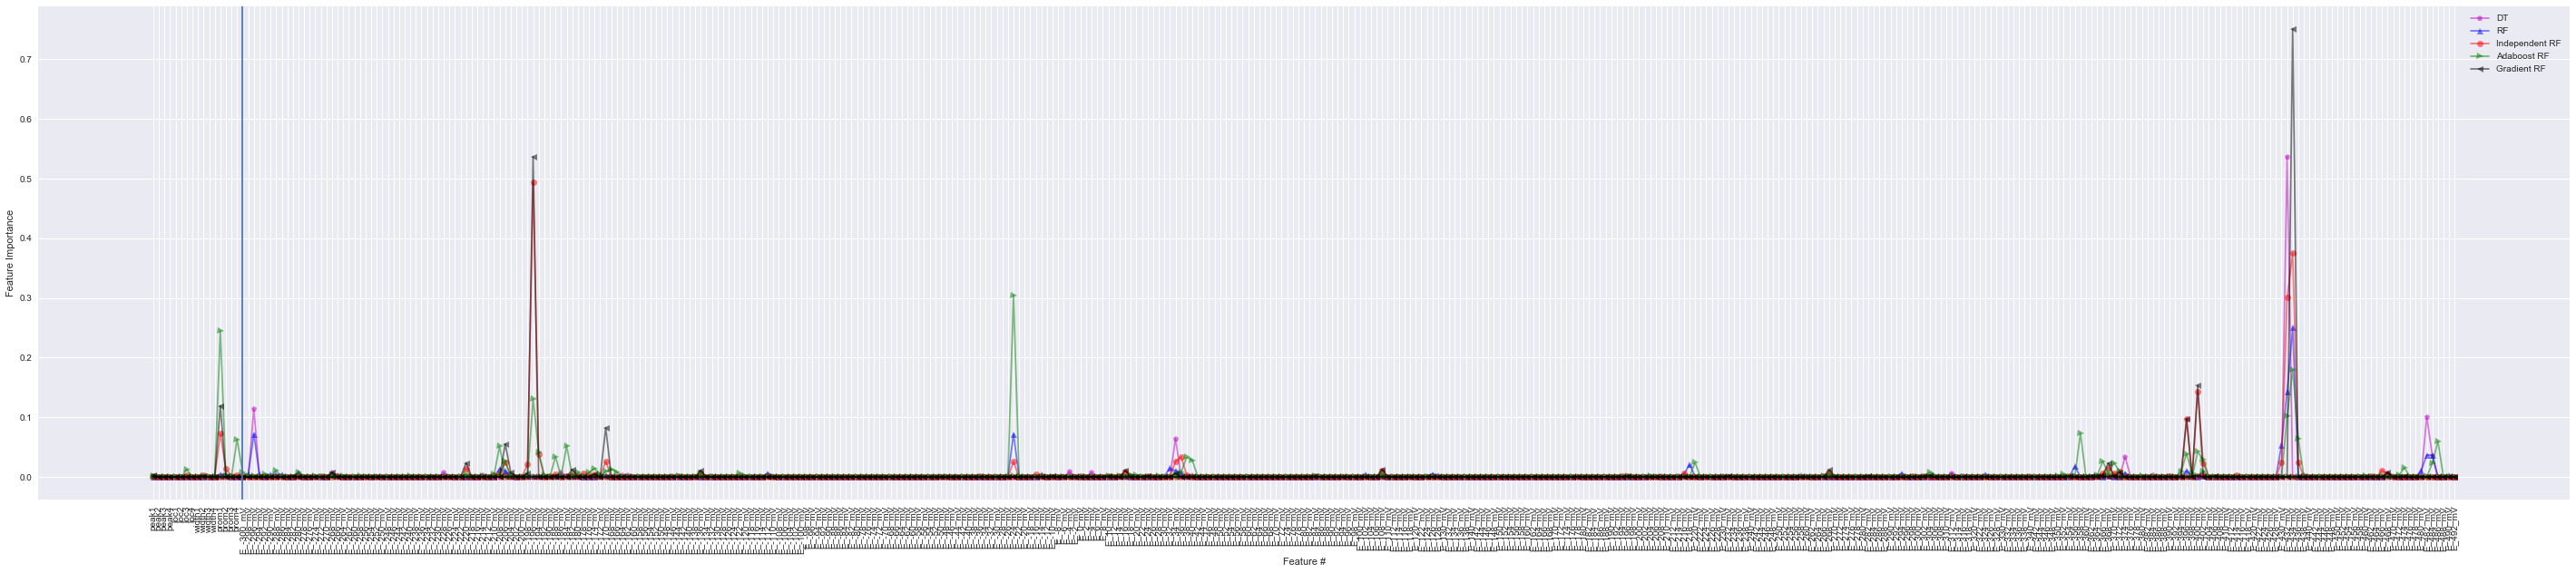

In [81]:
Features = linspace(0,413, 413)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')

(0, 50)

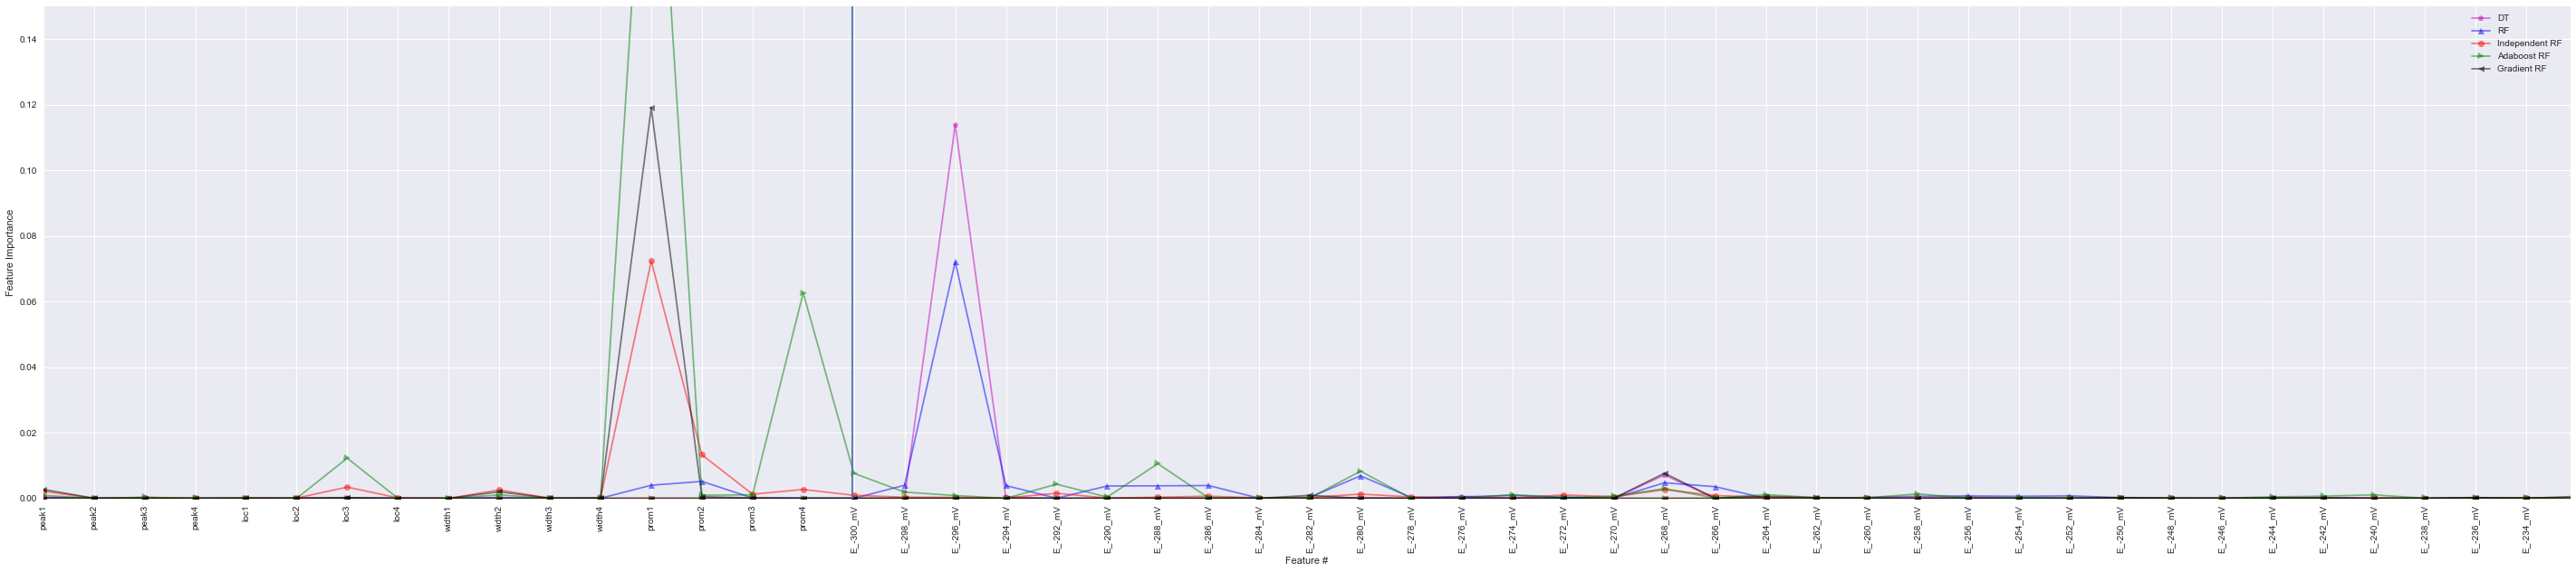

In [82]:
Features = linspace(0,413, 413)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')
ylim([0, 0.15])
xlim([0, 50])